In [1]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

In [2]:
import gym
import os
import sys
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
from q_learning_bins import plot_running_avg

In [8]:
# so you can test different architectures
class HiddenLayer:
    def __init__(self, M1, M2, f= T.tanh, use_bias= True):
        self.W = theano.shared(np.random.randn(M1, M2) / np.sqrt(M1+M2))
        self.params = [self.W]
        self.use_bias = use_bias
        if use_bias:
            self.b = theano.shared(np.zeros(M2))
            self.params += [self.b]
        self.f = f
    
    def forward(self, X):
        if self.use_bias:
            a = X.dot(self.W) + self.b
        else:
            a = X.dot(self.W)
        return self.f(a)
    

In [18]:
class DQN:
    def __init__(self, D, K, hidden_layer_sizes, gamma, max_experiences= 10000, min_experiences= 100, batch_sz= 32):
        self.K = K
        lr = 10e-4
        mu = 0.
        decay = 0.99
        
        # create the graph
        # K = number of actions
        self.layers = []
        M1 = D
        for M2 in hidden_layer_sizes:
            layer = HiddenLayer(M1, M2)
            self.layers.append(layer)
            M1 = M2
            
        # final layer
        layer = HiddenLayer(M1, K, lambda x: x, use_bias= False)
        self.layers.append(layer)
        
        # collect params for copy
        self.params = []
        for layer in self.layers:
            self.params += layer.params
        cache = [theano.shared(np.ones_like(p.get_value()*0.1)) for p in self.params]    
        velocities = [theano.shared(p.get_value()*0) for p in self.params]
        
        
        # inputs and targets
        X = T.matrix('X')
        G = T.vector('G')
        actions = T.ivector('actions')
           
        # calculate output and cost
        Z = X
        for layer in self.layers:
            Z = layer.forward(Z)
        Y_hat = Z
        
        selected_action_values = Y_hat[T.arange(actions.shape[0]), actions]
        cost = T.sum((G - selected_action_values)**2)
        
        # create train function
        grads = T.grad(cost, self.params)
        g_update = [(p, p + v) for p, v, g in zip(self.params, velocities, grads)]
        c_update = [(c, decay * c + (1 - decay) * g*g) for c, g in zip(cache, grads)]
        v_update = [(v, mu*v - lr*g / T.sqrt(c)) for v, c, g in zip(velocities, cache, grads)]
        # momentum option
        # v_update = [(v, mu*v - lr*g) for v, g in zip(velocities, grads)]
        # c_update = []
        updates = c_update + g_update + v_update
        
        # compile functions
        self.train_op = theano.function(
            inputs = [X, G, actions],
            updates = updates,
            allow_input_downcast = True
        )
        
        self.predict_op = theano.function(
            inputs = [X],
            outputs = Y_hat,
            allow_input_downcast = True
        )
        
        # create replay memory
        self.experience = {'s': [], 'a': [], 'r': [], 's2': []}
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences
        self.batch_sz = batch_sz
        self.gamma = gamma
        
    def copy_from(self, other):
        ops = []
        my_params = self.params
        other_params = other.params
        for p, q in zip(my_params, other_params):
            actual = q.get_value()
            p.set_value(actual)
    
    def predict(self, X):
        X = np.atleast_2d(X)
        return self.predict_op(X)
    
    def train(self, target_network):
        # sample a random batch from buffer, do an iteration of GD
        if len(self.experience['s']) < self.min_experiences:
            # don't do anything if we don't have enough experience
            return
        
        # randomly select a batch
        idx = np.random.choice(len(self.experience['s']), size= self.batch_sz, replace = False)
        # print("idx:", idx)
        states = [self.experience['s'][i] for i in idx]
        actions = [self.experience['a'][i] for i in idx]
        rewards = [self.experience['r'][i] for i in idx]
        next_states = [self.experience['s2'][i] for i in idx]
        next_Q = np.max(target_network.predict(next_states), axis= 1)
        targets = [r + self.gamma*next_q for r, next_q in zip (rewards, next_Q)]
        
        #call optimizar
        self.train_op(states, targets, actions)
    
    def add_experience(self, s, a, r, s2):
        if len(self.experience['s']) >= self.max_experiences:
            self.experience['s'].pop(0)
            self.experience['a'].pop(0)
            self.experience['r'].pop(0)
            self.experience['s2'].pop(0)
            
        self.experience['s'].append(s)
        self.experience['a'].append(a)
        self.experience['r'].append(r)
        self.experience['s2'].append(s2)
            
    
    def sample_action(self, x, eps):
        if np.random.random() < eps:
            return np.random.choice(self.K)
        else:
            X = np.atleast_2d(x)
            return np.argmax(self.predict(X)[0])
    


In [5]:
def play_one(env, model, tmodel, eps, gamma, copy_period):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    
    while not done and iters < 2000:
        # if we reach 2000, just quit, don't want this going forever
        # the 200 limit seems a bit early
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        
        totalreward += reward
        if done:
            reward = -200
            
        # update the model
        model.add_experience(prev_observation, action, reward, observation)
        model.train(tmodel)
        
        iters +=1
        
        if iters % copy_period == 0:
            tmodel.copy_from(model)
    
    return totalreward

In [6]:
def main():
    env = gym.make('CartPole-v0')
    gamma = 0.99
    copy_period = 50
    
    D = env.observation_space.shape[0]
    K = env.action_space.n
    sizes = [200, 200]
    model = DQN(D, K, sizes, gamma)
    tmodel = DQN(D, K, sizes, gamma)
   
    
    if 'monitor' in sys.argv:
        filename = os.path.basename(__file__).split('.')[0]
        monitor_dir = './' + filename + '_' + str(datetime.now())
        env = wrappers.Monitor(env, monitor_dir)
        
    N = 600
    totalrewards = np.empty(N)
    for n in range(N):
        eps = 1.0/np.sqrt(n+1)
        totalreward = play_one(env, model, tmodel, eps, gamma, copy_period)
        totalrewards[n] = totalreward
        if n % 100 == 0:
            print("episode:", n, "total reward:", totalreward, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())
            
    print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
    print("total steps:", totalrewards.sum())

    plt.plot(totalrewards)
    plt.title("Rewards")
    plt.show()

    plot_running_avg(totalrewards)

episode: 0 total reward: 9.0 avg reward (last 100): 9.0
episode: 100 total reward: 13.0 avg reward (last 100): 10.9801980198
episode: 200 total reward: 8.0 avg reward (last 100): 9.90099009901
episode: 300 total reward: 10.0 avg reward (last 100): 9.67326732673
episode: 400 total reward: 10.0 avg reward (last 100): 9.87128712871
episode: 500 total reward: 9.0 avg reward (last 100): 9.54455445545
avg reward for last 100 episodes: 9.42
total steps: 5939.0


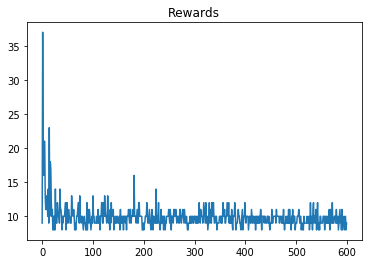

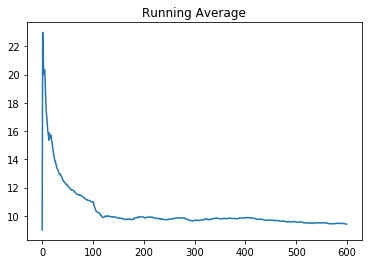

In [19]:
if __name__ == '__main__':
    main()